# Aplicación del modelo de lenguaje neuronal

El modelo del lenguaje neuronal propuesto por Bengio (2003) es un modelo que estima probabilidades a partir de una red neuronal FeddForward. Como otros modelos, se puede entender como una tupla:

$$\mu = (\Sigma, P)$$

donde $\Sigma$ es el vocabulario de palabras y $P = p(w_j|w_i)$ es la probabilidad de transición de $w_i$ a $w_j$. En este caso $P$ es una red FeedForward con una arquitectura constituida por:

* Una capa de embedding.
* Una capa oculta con activación $\tanh$.
* Una capa de salida con activación Softmax para obtener las probabilidades de transición.

A continuación mostramos una aplicación del modelo. No mostramos el modelo que en este caso es un script (<i>LM_bengio</i>). Por tanto, importamos este script y la paqueteria necesaria.

In [1]:
#Script que contiene el modelo del lenguaje de Bengio
from LM_Bengio import Model
#Otros paquetes
import numpy as np
from collections import defaultdict, Counter
from itertools import chain
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from operator import itemgetter

Definimos tres funciones:

* Función para crear el vocabulario: asocia índices numéricos a palabras
* Función para asociar a cada elemento, una palabra
* Función para  visualizar los embeddings por reducción de dimensionalidad con PCA

In [2]:
#Funcion que crea un vocabulario de palabras con un indice numerico
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)
    return vocab    

#Funcion que pasa la cadena de simbolos a una secuencia con indices numericos
def text2numba(corpus, vocab):
    for doc in corpus:
        yield [vocab[w] for w in doc]

#Función para visualizar los embeddings
#Usa reducción de la dimensionalidad por PCA
def plot_words(Z,ids):
    Z = PCA(2).fit_transform(Z)
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c='blue')
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
    plt.show()

### Preparación de los datos de entrenamiento

Los datos de entrenamiento serán obtenidos de los bigramas de tal forma que:

$$\mathcal{S} = \{(i,j) : (w_i,w_j) \text{ es un bigrama}\}$$

En primer lugar creamos el vocabulario, indexamos las palabras, agregamos los símbolos de inicio, BOS, y final, EOS a cada cadena.

In [3]:
corpus = ['el perro come un hueso', 'un muchacho jugaba', 'el muchacho saltaba la cuerda',
          'un perro come croquetas']

#Llamamos la funcion para crear el vocabulario
idx = vocab()
#Creamos el vocabulario y le asignamos un indice a cada simbolo segun su aparicion
cads_idx = list(text2numba([s.split() for s in corpus],idx))

#Indicamos las etiquetas a usar
EOS = '<EOS>'
BOS = '<BOS>'

#Cada etiqeuta se le asigna un indice numerico
BOS_IDX = max(idx.values())+2
EOS_IDX = max(idx.values())+1

#Se agregan estas etiqeutas al vocabulario
idx[EOS] = EOS_IDX
idx[BOS] = BOS_IDX

#A cada cadena se le agrega la etiqueta BOS al inicio y EOS al final
cadenas = [[BOS_IDX] + cad + [EOS_IDX] for cad in cads_idx]

#Se obtiene la longitud del alfabeto
N = len(idx)

De aquí, obtenemos los bigramas. Estos serán pares de números, pues a partir de estos se pueden obtener los one-hot vectors y la neurona de activación de la salida.

In [4]:
#Se crean los bigramas
bigrams = list(chain(*[zip(cad,cad[1:]) for cad in cadenas]))

#Se obtiene la frecuencia de cada bigrama
frecBigrams = Counter(bigrams)

print(bigrams)

[(12, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 11), (12, 3), (3, 5), (5, 6), (6, 11), (12, 0), (0, 5), (5, 7), (7, 8), (8, 9), (9, 11), (12, 3), (3, 1), (1, 2), (2, 10), (10, 11)]


### Entrenamiento del modelo

Si bien no presentamos el modelo de manera explícita, aplicamos este a los datos señalando los hiperparámetros y los resultados que de este se obtienen.

In [5]:
model = Model(bigrams, idx, dim_emb=2, nn_hdim=3)

En primer lugar, entrenamos la red señalando el número de iteraciones y el rango de aprendizaje:

In [6]:
model.train(its=50, eta=0.1)

100%|██████████| 50/50 [00:00<00:00, 621.49it/s]


Con el entrenamiento, hemos obtenido los pesos de la red óptimos que solucionan el problema. En este caso, hemos encontrado los pesos de la red que determinan la mejor función de probabilidad. Entonces podemos aplicar la red para obtener las probabilidades de transición:

In [7]:
model.forward('el')

{'el': 0.0004744082760160536,
 'perro': 0.4134975418958695,
 'come': 0.018646032601559916,
 'un': 0.00030276916006895466,
 'hueso': 0.13432195331056138,
 'muchacho': 0.39269287946282455,
 'jugaba': 0.0009214867341456758,
 'saltaba': 0.0011378085905999862,
 'la': 0.00992245949166231,
 'cuerda': 0.0007962470884510516,
 'croquetas': 0.0003332868260387378,
 '<EOS>': 0.02695312656220175}

Finalmente, podemos observar el comportamiento de los embeddings, los cuales se aprendieron también durante el proceso de aprendizaje de la red:

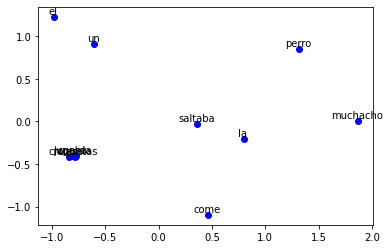

In [9]:
label = [w[0] for w in sorted(idx.items(), key=itemgetter(1))]
plot_words(model.C.T[:-2],label[:-2])

# Modelo del lenguaje de un texto

Ahora que hemos visto cómo se aplica el modelo de lenguaje de Bengio, podemos aplicarlo a un texto particular, que nos permitirá evaluar la calidad del modelo:

In [10]:
from nltk.corpus import cess_esp
from sklearn.model_selection import train_test_split
from nltk.tokenize import sent_tokenize, word_tokenize

### Preparación del texto

Obtenemos las sentencias con las que vamos a trabajar. Tokenizamos por oraciones y cada oración, a su vez, es tokenizada por palabras para obtener los elementos que servirán para el modelo del lenguaje.

Posteriormente, separamos los datos del corpus en el corpus de entrenamiento y el de evaluación:

In [11]:
#Obtener las sentencias del cuento
#Aleph de borges
sents = [word_tokenize(s) for s in sent_tokenize(open('borges_aleph.txt','r').read())]

#Split en corpus train y test
corpus, corpus_eval = train_test_split(sents, test_size=0.3)

print('Número de cadenas train:',len(corpus))
print('Número de cadenas test:',len(corpus_eval))

Número de cadenas train: 135
Número de cadenas test: 58


También podemos ver el número de tipos y tokens con el que cuenta el texto:

In [12]:
#Frecuencia de los tipos
freq_words= Counter( chain(*[' '.join(sent).lower().split() for sent in corpus]) )

print('Número de tipos: {} \nNúmero de tokens: {}'.format(len(freq_words), sum(freq_words.values())))

Número de tipos: 1445 
Número de tokens: 3934


### Sustitución de los hapax 

Ahora sustituiremos elementos del texto por el símbolo de fuera del vocabulario (Out Of Vocabulary) o $OOV$ esto nos permitirá manejar elementos que no se observen durante el entrenamiento.

In [13]:
#Nuevo corpus remplazando hápax por OOV
corpus_hapax = []
#Reemplazamos los hápax por OOV
for sent in corpus:
  sent_hapax =[]
  for w in sent:
    #Si es hápax
    if freq_words[w.lower()] == 1:
      #Se reemplaza por <oov>
      sent_hapax.append('<oov>')
    else:
      #De otra forma se mantiene la palabra en mínuscula
      sent_hapax.append(w.lower())
  #Se agrupan las cadenas    
  corpus_hapax.append(sent_hapax)

### Obtención de los pares de entrenamiento

Antes de entrenar el modelo del lenguaje obtendremos los pares de entrenamiento que serán los pares obtenidos de bigramas, de tal forma que nuestro conjunto supervisado será:

$$\mathcal{S} = \{(i,j) : (w_i, w_j) \text{ es un bigrama}\}$$

Antes de obtener estos bigramas, además, debemos agregar los símbolos de $BOS$ y $EOS$, así como crear el vocabulario:

In [14]:
voc = vocab()
#Creamos el vocabulario y le asignamos un indice a cada simbolo segun su aparicion
cads_idx = list(text2numba(corpus_hapax,voc))
#Indicamos las etiquetas a usar
EOS = '<EOS>'
BOS = '<BOS>'
#Cada etiqeuta se le asigna un indice numerico
BOS_IDX = max(voc.values())+2
EOS_IDX = max(voc.values())+1
#Se agregan estas etiqeutas al vocabulario
voc[EOS] = EOS_IDX
voc[BOS] = BOS_IDX
#A cada cadena se le agrega la etiqueta BOS al inicio y EOS al final
cadenas = [[BOS_IDX] + cad + [EOS_IDX] for cad in cads_idx]
#Se crean los bigramas
bigrams = list(chain(*[zip(cad,cad[1:]) for cad in cadenas]))

print(bigrams[:10])

[(298, 0), (0, 1), (1, 1), (1, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7)]


## Entrenamiento del modelo

Ahora podemos pasar a entrenar el modelo. Para esto, señalamos el número de iteraciones y el rango de aprendizaje:

In [15]:
%%time
#Entrenamiento de la red
big_model = Model(bigrams, voc, dim_emb=100, nn_hdim=300)
big_model.train(its=50, eta=0.1)

100%|██████████| 50/50 [04:39<00:00,  5.60s/it]

CPU times: user 23min 49s, sys: 24min 45s, total: 48min 34s
Wall time: 4min 39s


### Evaluación del modelo

Para evalaur el modelo, necesitamos primero definir una función que nos de la probabilidad de las cadenas. Definimos esta función a continuación

In [16]:
def prob_sent(sent):
    #Obtenemos los simbolos
    seq = sent.split()
    #Obtenemos los bigramas de la cadena de evaluacion
    bigrSeq = zip(seq,seq[1:])
    
    #Guardamos la probabilidad inicial dado el modelo
    try:
        p = big_model.forward('<BOS>')[seq[0]]
    except: 
        p = big_model.forward('<BOS>')['<oov>']
    #Multiplicamos por las probabilidades de los bigramas dado el modelo
    for gram1, gram2 in bigrSeq:
        #Obtiene las probabilidades de transición
        #Dado el primer elemento
        try:
            prev_prob = big_model.forward(gram1)
        #En caso de que sea una OOV
        except:
            prev_prob = big_model.forward('<oov>')
        #Obtiene la probabilidad de transitar a la siguiente palabra
        try:
            p *= prev_prob[gram2]
        #En caso de que sea una OOV
        except:
            p *= prev_prob['<oov>']
            
    return p 

In [17]:
prob_sent('el aleph es un cuento')

4.635405767151419e-08

Ya con esto, podemos evaluar el modelo con entropía empírica (tomamos el promedio por cadena de ésta). Asimismo, con base en la entropía empírica podemos obtener la perplejidad como:

$$Px(\mu) = 2^{H(\mu)}$$

In [18]:
#Evaluación del modelo
H = 0.0
for cad in corpus_eval:
    #Probabilidad de la cadena
    p_cad = prob_sent(' '.join(cad))
    #Longitud de la cadena
    M = len(cad)
    #Obtenemos la entropía cruzada de la cadena
    if p_cad == 0:
        pass
    else:
        H -= (1./M)*(np.log(p_cad)/np.log(2))
        
H = H/len(corpus_eval)

print('Entropía promedio: {}\nPerplejidad total: {}'.format(H,2**H))

Entropía promedio: 5.0019962442820525
Perplejidad total: 32.044308762816854


## Aplicaciones del modelo

Para acabar, presentamos algunas aplicaciones del modelo. Ya hemos visto que con este se pueden obtener las probabilidades de cadenas. También podemos obtener las palabras con mayor probabilidad de seguir a una palabra de entrada:

In [19]:
#Función para obtener las probabilidades ordenadas de mayor a menor
def get_ordered_probs(word):
    probs = big_model.forward(word)
    probs.pop('<oov>')
    return sorted(probs.items(), key=itemgetter(1), reverse=True)

In [20]:
get_ordered_probs('la')[:10]

[('que', 0.029063084261079536),
 ('historia', 0.019388641754210623),
 ('casa', 0.007078160725972961),
 ('escalera', 0.00574433162048245),
 ('mezquita', 0.0041154306658089685),
 ('obra', 0.003932688562187116),
 ('calle', 0.003399977538639194),
 ('tierra', 0.0029985924198209562),
 ('mi', 0.0028195300256241202),
 ('primera', 0.0027053231075902027)]

### Generación de lenguaje

Una de las aplicaciones típicas de los modelos del lenguaje es generar lenguaje. Para esto definiremos una función que predice una palabra siguiente y la aplicaremos de manera iterativa.

In [21]:
#Función que genera una palabra siguiente
def next_word(string):
    #Obtener la última palabra en la historia
    last_w = string.split()[-1]
    #Obtener una palabra en base a la distribución
    selection = np.random.choice(range(1), 1, p=None)[0]
    max_w = get_ordered_probs(last_w)[selection]
    #max_w = get_ordered_probs(last_w)[0]
    
    return max_w

#Función que genera cadena
def generate(string):
    #Guarda la palabra predicha
    w = ''
    #Guarda la cadena que se ha generado
    str_gen = string
    #El método se detiene al ver <EOS>
    t = 0
    while w != '<EOS>':
        #Predice la siguiente palabra
        w, p = next_word(str_gen)
        #Agrega esa palabra a ala cadena
        str_gen += ' ' + w
        t += 1
        if t == 100:
            w = '<EOS>'
    
    #Regresa la cadena si el símbolo EOS
    return str_gen[:len(str_gen)]

In [22]:
generate('la poesía es')

'la poesía es muy poco , infinita . <EOS>'

# Generalización del modelo

Una generalización del modelo que permite la arquitectura neuronal es considerar varias entradas previas, varias palabras precedentes, que den lugar a la probabilidad de la palabra siguiente.

Como se genera un modelo de embedding, se asume que se pueden representar las cadenas de palabras como el promedio de los embeddings que los conforman, esto es, si tenemos una cadena $w_{i_1}, w_{i_2},...,w_{i_T}, su embedding será:

$$C(i_1,i_2,...,i_T)  = \frac{1}{T}\sum_{t=1}^T C(i_t)$$

Podemos tomar este embedding para correr la red sobre él y obtener la prbabilidad:

$$p(w_j|w_{i_1}, w_{i_2},...,w_{i_T}) = \phi(w_{i_1}, w_{i_2},...,w_{i_T})$$

Donde $\phi(w_{i_1}, w_{i_2},...,w_{i_T})$ es la red aplicada a estas palabras previas.

In [23]:
#Función para una entrada múltiple
#toma los pesos aprendidos del modelo simple
def multi_forward(prev_words):
    #Suma de embeddings
    c_w = sum([big_model.C.T[voc[word]] for word in prev_words.split(' ')])
    #Capa oculta
    h = np.tanh(big_model.U@c_w + big_model.b)
    #Capa de salida
    out = np.exp(big_model.W@h + big_model.c)
    p = out/out.sum()
    
    return {list(voc.keys())[i]:p[0][i] for i in range(len(p[0]))}

In [24]:
def multi_ordered_probs(word):
    probs = multi_forward(word)
    probs.pop('<oov>')
    return sorted(probs.items(), key=itemgetter(1), reverse=True)

multi_ordered_probs('el poema de')[:10]

[('se', 0.05286211976880284),
 ('que', 0.02544670504726472),
 ('grandes', 0.015038480159444626),
 (';', 0.007763425196366063),
 ('los', 0.006921023546869526),
 ('dos', 0.005694426016535696),
 (',', 0.00418210152379105),
 ('aleph', 0.0027555227259215115),
 ('cargo', 0.002556345976682709),
 ('sé', 0.0024710006052271485)]

Con esta generalización ta,bién podemos generar lenguaje. En este caso, la en cada paso se observará toda la cadena generada hasta ese momento:

In [25]:
def multi_generate(string):
    #Guarda la palabra predicha
    w = ''
    #Guarda la cadena que se ha generado
    str_gen = string
    #El método se detiene al ver <EOS>
    t = 0
    while w != '<EOS>':
        #Predice la siguiente palabra
        selection = np.random.choice(range(3), 1, p=None)[0]
        w, p = multi_ordered_probs(str_gen)[selection]
        #Agrega esa palabra a ala cadena
        str_gen += ' ' + w
        t += 1
        if t == 100:
            w = '<EOS>'
    
    #Regresa la cadena si el símbolo EOS
    return str_gen[:len(str_gen)]

In [26]:
multi_generate('el poema')

'el poema se había aleph , es la ahora la letra considerable y , hasta hace muy poco bien bien bien nos ... claro , poco claro otro claro está está , mis está , como infinita mis observó , , como bajo como si mis bajo si si observó bien si bien poco poco poco después después si , poco poco poco , después poco , . después después después murió , poco , después , después después murió , , , después después murió después observó observó bajo después observó observó fuera si después después después si murió observó después'

### Visualización de los embeddings

El modelo también aprende las representaciones vectoriales de las palabras que pueden representarse en un espacio vectorial:

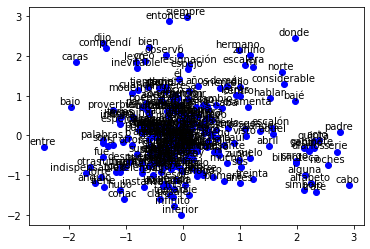

In [27]:
label = [w[0] for w in sorted(voc.items(), key=itemgetter(1))]
plot_words(big_model.C.T[:-2],label[:-2])